### Tripadvisor Review Analysis
In recent years, the use of NLP has become widely common in marketing and sales analysis. With the amount of non-numeric data available in the form of comments, reviews, and survey responses, utilizing NLP tools can help organizations extract valuable information. 

The goal of this project is to utilize NLP tools in Python to analyze customer reviews, identify trends as well as potential problems. 



### Import Libaries

In [68]:
## All purpose
import pandas as pd 
import numpy as np
import string

## Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud

## NLP
from nltk.probability import FreqDist
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import TweetTokenizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

## Deeplearning/ML
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow.keras.layers as L
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, GRU

### Data Exploration

In [2]:
data = pd.read_csv('b.csv', delimiter = ',', encoding='ISO-8859-1')
data = data.set_index('S.No.', drop=True)

In [3]:
data

Review  Rating
S.No.                                                           
1      nice hotel expensive parking got good deal sta...       4
2      ok nothing special charge diamond member hilto...       2
3      nice rooms not 4* experience hotel monaco seat...       3
4      unique \tgreat stay \twonderful time hotel mon...       5
5      great stay great stay \twent seahawk game awes...       5
...                                                  ...     ...
20487  best kept secret 3rd time staying charm \tnot ...       5
20488  great location price view hotel great quick pl...       4
20489  ok just looks nice modern outside \tdesk staff...       2
20490  hotel theft ruined vacation hotel opened sept ...       1
20491  people talking \tca n't believe excellent rati...       2

[20491 rows x 2 columns]

In [4]:
len(data)

20491

### Data preprocessing - VADER-Sentiment-Analysis

In [5]:
## Creating sentimental polarity 
analyzer = SentimentIntensityAnalyzer()
def compound_score(txt):
    return analyzer.polarity_scores(txt)["compound"]

## Sentiments
def sentiment(score):
    emotion = ""
    if score >= 0.5:
        emotion = "Positive"
    elif score <= -0.5:
        emotion = "Negative"
    else:
        emotion = "Neutral"
    return emotion

In [6]:
## Applying Compound score
polarity_scores = data["Review"].astype("str").apply(compound_score)
data["Sentiment_Score"] = polarity_scores

## Applying Sentiment
data["Sentiment"] = data["Sentiment_Score"].apply(sentiment)

In [7]:
data = data.reset_index(drop=True)

In [8]:
## Fixed the tabs and other formatting error made while extracting the reviews
data = data.replace(' \t', ', ', regex=True)
data = data.replace('\sn\'t', 'n\'t', regex=True)
data

Review  Rating  \
0      nice hotel expensive parking got good deal sta...       4   
1      ok nothing special charge diamond member hilto...       2   
2      nice rooms not 4* experience hotel monaco seat...       3   
3      unique, great stay, wonderful time hotel monac...       5   
4      great stay great stay, went seahawk game aweso...       5   
...                                                  ...     ...   
20486  best kept secret 3rd time staying charm, not 5...       5   
20487  great location price view hotel great quick pl...       4   
20488  ok just looks nice modern outside, desk staffn...       2   
20489  hotel theft ruined vacation hotel opened sept ...       1   
20490  people talking, can't believe excellent rating...       2   

       Sentiment_Score Sentiment  
0               0.9626  Positive  
1               0.9870  Positive  
2               0.9852  Positive  
3               0.9920  Positive  
4               0.9870  Positive  
...                ...       ...  
20486           0.9699  Positive  
20487           0.9753  Positive  
20488           0.2629   Neutral  
20489           0.9776  Positive  
20490          -0.0003   Neutral  

[20491 rows x 4 columns]

In [9]:
### Check for missing values in the data
data.isna().sum()

Review             0
Rating             0
Sentiment_Score    0
Sentiment          0
dtype: int64

### Exploratory Analysis
In this part, we'll explore the distribution of ratings and sentiment.

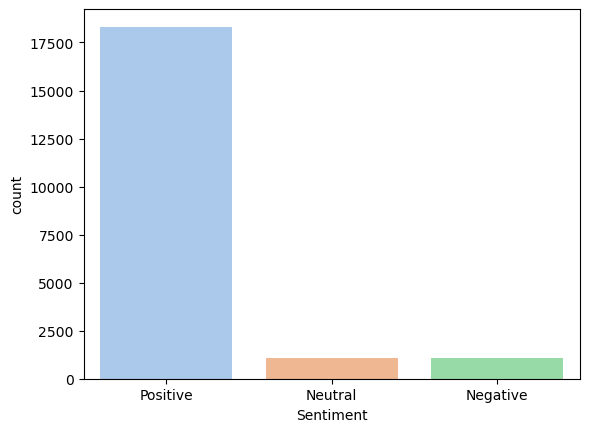

In [10]:
sns.countplot(data=data,x="Sentiment",palette="pastel");

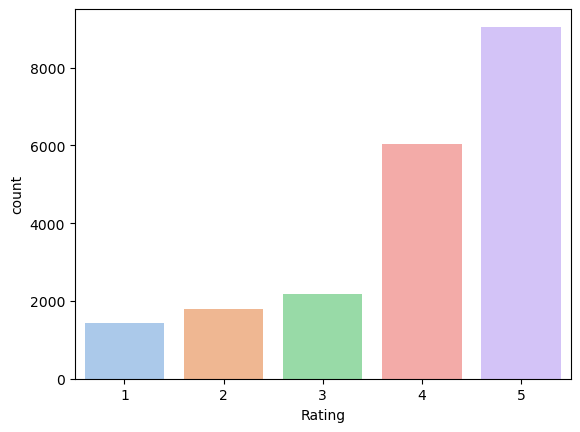

In [11]:
sns.countplot(data=data,x="Rating",palette="pastel");

#### Distribution of sentiment across each group of rating

In [12]:
Viz_1 = data['Rating'].value_counts().rename_axis(['Rating']).reset_index(name='counts')
fig_pie = px.pie(values=Viz_1.counts, names=Viz_1.Rating, title='Rating Distribution of the data',color_discrete_sequence=px.colors.qualitative.Pastel)
fig_pie.show()

In [13]:
Viz_2 = data[['Rating','Sentiment']].value_counts().rename_axis(['Rating','Sentiment']).reset_index(name='counts')
fig = px.bar(x=Viz_2.Rating, y=Viz_2.counts, color=Viz_2.Sentiment,color_discrete_sequence=px.colors.qualitative.Pastel,title="Sentiment & Ratings",labels={'x':'Ratings','y':'Total Number'})
fig.show()

As seen from this plot, there are two distinct patterns for the association between ratings and review sentiment.
* For lower ratings (1, 2), the sentiment is splitted between 3 groups.
* On the other hand, the reviews from customers who left higher ratings (3, 4, 5) are mostly classified as positive. 

It is unexpected that some customers who rated the service poorly left positive reviews. Hence, further investigation for this group is suggested. 


#### Sentiment Score Analysis

#### Jointplot 
The following jointplot showcases the relationship between Rating and Sentiment Score

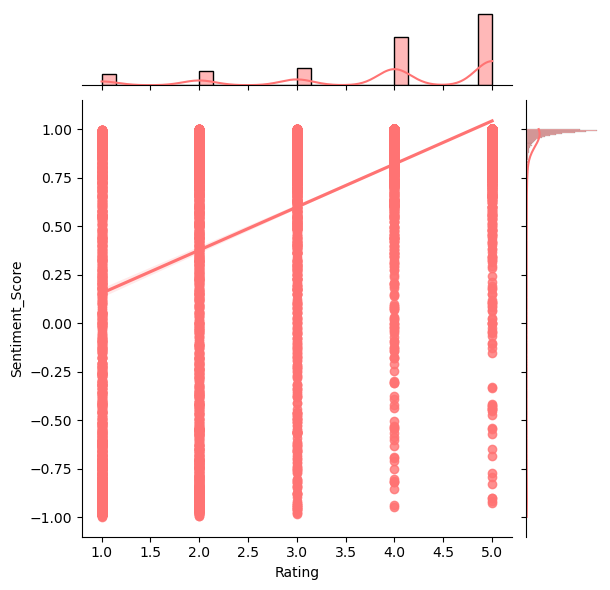

In [14]:
jp = sns.jointplot(data=data,x='Rating',y='Sentiment_Score',kind="reg",color='#ff7373')


### Wordcloud of Different Sentiments

In [15]:
data.head()

Review  Rating  Sentiment_Score  \
0  nice hotel expensive parking got good deal sta...       4           0.9626   
1  ok nothing special charge diamond member hilto...       2           0.9870   
2  nice rooms not 4* experience hotel monaco seat...       3           0.9852   
3  unique, great stay, wonderful time hotel monac...       5           0.9920   
4  great stay great stay, went seahawk game aweso...       5           0.9870   

  Sentiment  
0  Positive  
1  Positive  
2  Positive  
3  Positive  
4  Positive

In [16]:
def wordcloud(Sentiment):
    text1 =''
    for i in data[data['Sentiment']==Sentiment]['Review'].values:
        text1+=i + ' '

    wc = WordCloud(width = 400, height = 400,background_color="white",min_font_size = 10,\
        repeat=True,).generate(text1)
    return wc;

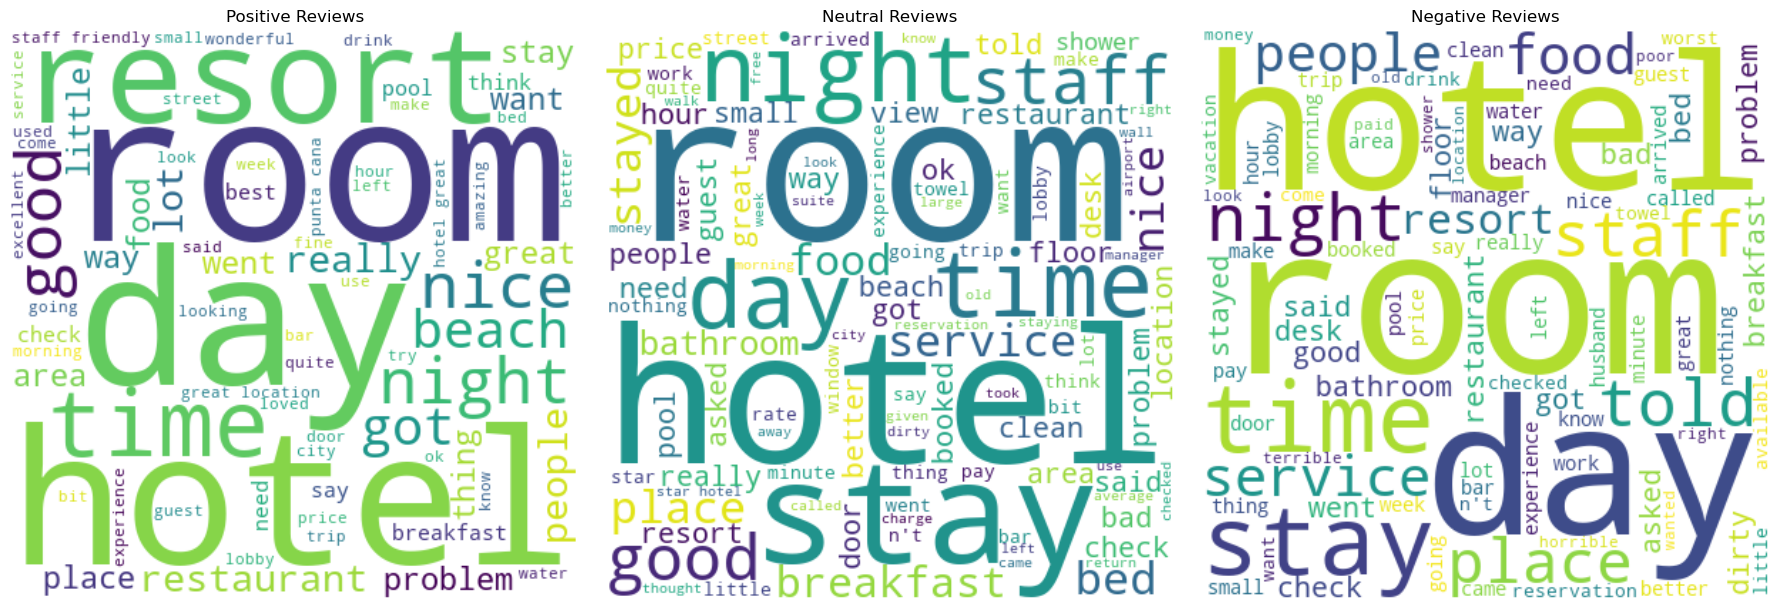

In [18]:
#Compile the wordclouds for all 3 ratings

wc1 = wordcloud("Positive")
wc2 = wordcloud("Neutral")
wc3 = wordcloud("Negative")

# Set up the matplotlib figure
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot each wordcloud
axes[0].imshow(wc1, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('Positive Reviews')

axes[1].imshow(wc2, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('Neutral Reviews')

axes[2].imshow(wc3, interpolation='bilinear')
axes[2].axis('off')
axes[2].set_title('Negative Reviews')

# Use Seaborn to style the plot
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

In [20]:
stop_words =  set(open('stopwords.txt').read().split())

In [21]:
### Extract the top used words in each review category
def get_frequency(data,Sentiment):
    text =''
    for i in data[data['Sentiment']==Sentiment]['Review'].values:
        text+=i + ' '
    #Remove punctuation (except apostrophe)
    punc = string.punctuation.replace("'", "")
    text = text.translate(str.maketrans('', '', punc))
    #Tokenize words
    text = word_tokenize(text)
    #Remove stopwords
    text = [word for word in text if word.lower() not in stop_words]
    #Get frequency
    word_freq = FreqDist(text)
    # Get the most common words
    most_common_words = word_freq.most_common(10)
    # Convert to DataFrame for plotting
    words_df = pd.DataFrame(most_common_words, columns=['Word', 'Frequency'])
    return words_df;

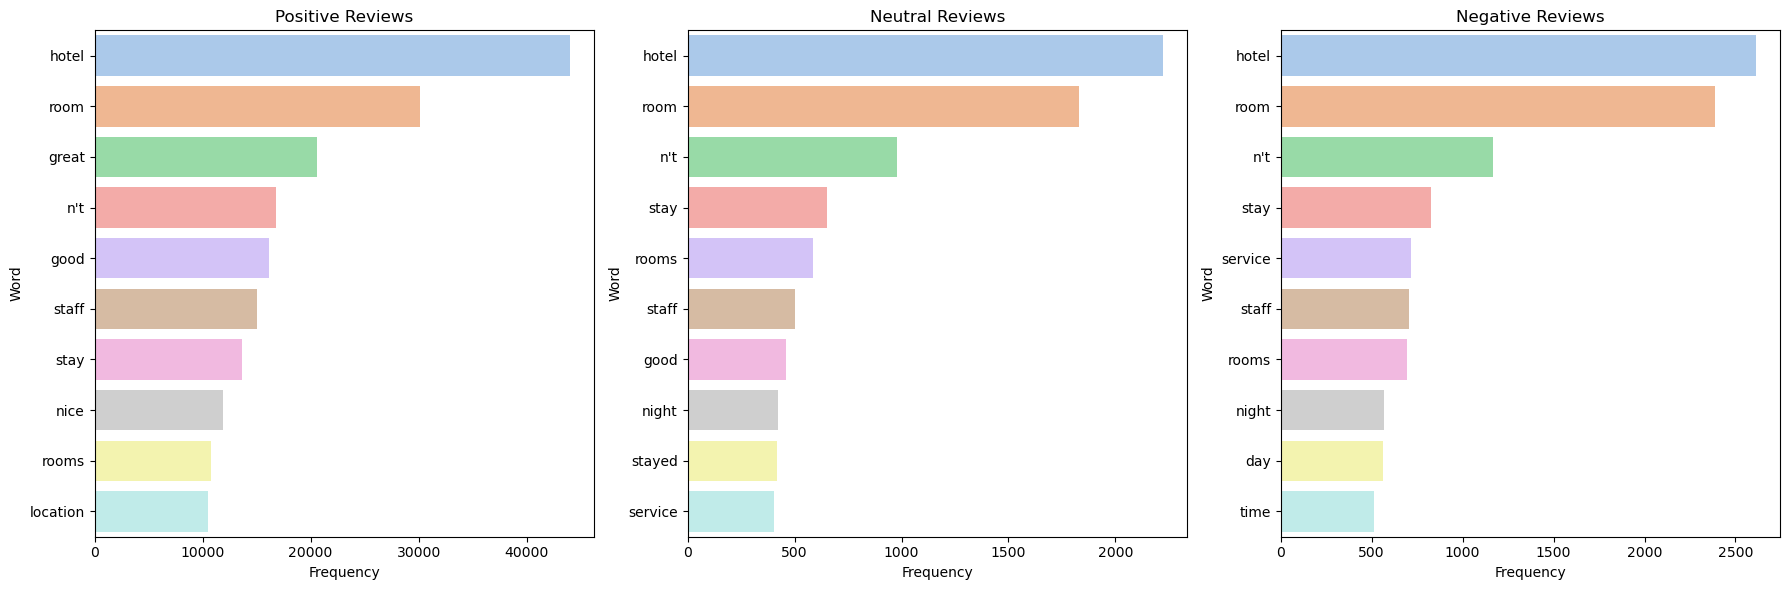

In [22]:
# Plot 3 frequencies
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.set_palette("pastel")

pos = get_frequency(data,"Positive")
sns.barplot(pos, x="Frequency", y="Word", ax=axes[0])
axes[0].set_title('Positive Reviews')

neu = get_frequency(data,"Neutral")
sns.barplot(neu, x="Frequency", y="Word", ax=axes[1])
axes[1].set_title('Neutral Reviews')

neg = get_frequency(data,"Negative")
sns.barplot(neg, x="Frequency", y="Word", ax=axes[2])
axes[2].set_title('Negative Reviews')

# Use Seaborn to style the plot
plt.tight_layout()
plt.show()

After removing stopwords and punctuation, we get a better picture of the common topics mentioned in the reviews. For instance, positive reviews often mention with the hotel rooms' quality and location. On the other hand, negative reviewers are concerned about customers' stay, "day", "night", and "time", implying a possible issue with the hotel services during certain times of the day. 

To further improve accuracy and identify more specific problems, we can remove the most frequently mentioned topics like "room" or "hotel", and repeat the process. 

### Topic Modeling

In [23]:
from gensim import corpora, models

# Prepare text data
texts = [review.split() for review in data['Review']]

# Create dictionary and corpus
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Train LDA model
lda_model = models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)

In [24]:
for topic_id, topic_str in lda_model.print_topics():
    # Extract words from topic string
    words = [part.split('*"')[1].replace('"', '') for part in topic_str.split(' + ')]
    # Print topic number and words
    print(f"Topic {topic_id}: {', '.join(words)}")

Topic 0: hotel, great, room, staff, good, location, stay, breakfast, stayed, rooms
Topic 1: bali, singapore, villa, ubud, ritz, villas, kuta, nusa, bali,, spa
Topic 2: not, beach, food, resort, pool, great, just, good, people, did
Topic 3: airport, taxi, shuttle, bus, driver, eggs, airport,, cab, bacon, card
Topic 4: room, not, hotel, no, did, stay, night, rooms, desk, service


In [25]:
### Classification using Bidirectional LSTM & Keras

In [54]:
X = data["Review"].values
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

In [55]:
X = tokenizer.texts_to_sequences(X)

In [80]:
max_length = max([len(x) for x in X])
vocab_size = len(tokenizer.word_index)+1
X = pad_sequences(X, padding='post', maxlen=600)
          
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(data['Rating'])

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

In [86]:
### Defining hyperparameters
EMBEDDING_DIMENSION = 64
VOCABULARY_SIZE = 2000
MAX_LENGTH = 100
OOV_TOK = '<OOV>'
TRUNCATE_TYPE = 'post'
PADDING_TYPE = 'post'

In [87]:
###CODE WITH ERROR
model = tf.keras.Sequential([
    L.Embedding(input_dim=5000, output_dim=64),
    L.Bidirectional(LSTM(64, return_sequences=True)),
    L.Dropout(0.5),
    L.Bidirectional(LSTM(32)),
    L.Dense(32, activation='relu'),
    L.Dense(1, activation='softmax')  
])

model.compile(loss='sparse_categorical_crossentropy',  
              optimizer='adam',
              metrics=['accuracy'])

In [94]:
model = tf.keras.Sequential([
    L.Embedding(input_dim=5000, output_dim=64),
    L.Bidirectional(LSTM(64, return_sequences=True)),
    L.Dropout(0.5),
    L.Bidirectional(LSTM(32)),
    L.Dense(32, activation='relu'),
    L.Dense(5, activation='softmax')  # Ensure the output layer matches the number of classes
])

model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])

In [96]:
### Model training
history = model.fit(X_train, y_train, epochs=2, validation_data=(X_test, y_test), batch_size=64)

Epoch 1/2
257/257 ━━━━━━━━━━━━━━━━━━━━ 277s 1s/step - accuracy: 0.5461 - loss: 1.0075 - val_accuracy: 0.6172 - val_loss: 0.8699
Epoch 2/2
257/257 ━━━━━━━━━━━━━━━━━━━━ 278s 1s/step - accuracy: 0.6616 - loss: 0.7732 - val_accuracy: 0.6480 - val_loss: 0.8363


In [97]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy}')


129/129 ━━━━━━━━━━━━━━━━━━━━ 19s 146ms/step - accuracy: 0.6486 - loss: 0.8243
Test Accuracy: 0.6479629278182983
